<table style='border: none' align='left'>
   <tr style='border: none'>
      <th style='border: none'><font face='verdana' size='5' color='black'><b>Use XGBoost to classify tumors with IBM Watson Machine Learning</b></th>
      <th style='border: none'><img src='https://github.com/pmservice/customer-satisfaction-prediction/blob/master/app/static/images/ml_icon_gray.png?raw=true' alt='Watson Machine Learning icon' height='40' width='40'></th>
   </tr>
   <tr style='border: none'>
       <th style='border: none'><img src='https://raw.githubusercontent.com/pmservice/wml-sample-notebooks/master/images/cancer_banner-06.png' alt='Icon' width='700'> </th>
   </tr>
</table>

This notebook demonstrates how to obtain data from the IBM Watson Studio Gallery, create a predictive model, and score the model.

You will use a publicly available data set, the Breast Cancer Wisconsin (Diagnostic) Data Set, to train an XGBoost Model to classify breast cancer tumors (as benign or malignant). There are 569 data points in the Breast Cancer Wisconsin (Diagnostic) Data Set, and each data point has a set of predictors such as radius, texture, perimeter, and area. XGBoost stands for “E<b>x</b>treme <b>G</b>radient <b>Boost</b>ing”.

The XGBoost classifier makes its predictions based on the majority vote from a collection of models which are a set of classification trees. It combines weak learners to create a single strong learner. It is a sequential training process where new learners focus on the misclassified examples of previous learners.


The notebook uses `scikit-learn 0.20`, `xgboost 0.82`, and `watson-machine-learning-client-V4`.


Some familiarity with Python is helpful. This notebook is compatible WSL 2.1 and Python 3.6.


## Learning goals

You will learn how to:

-  Load a `csv` file into a Pandas DataFrame
-  Explore data
-  Prepare data for training and evaluation
-  Create an XGBoost machine learning model
-  Train and evaluate the model
-  Use cross-validation to optimize model's hyperparameters
-  Save the model
-  Deploy the model for batch scoring
-  Score test data


## Table of Contents

This notebook contains the following parts:

1.	[Load and explore the data](#load)
2.	[Create an XGBoost model](#model)<br>
    2.1 [Split data](#prepare)<br>
    2.2 [Create an XGBoost model](#create)<br>
3.  [Setting up](#setup)<br>
4.	[Save the model](#save)<br>
5.	[Deploy and score the model](#deploy)<br>
6.	[Summary and next steps](#summary)

To get started on WSL, find documentation on installation and set up <a href="https://www.ibm.com/support/knowledgecenter/SSHGWL_2.1.0/wsj/local/welcome.html" target="_blank" rel="noopener no referrer">here</a>.

-  Local Python environment configurations:
  + Python 3.6
  + XGBoost
  + watson-machine-learning-client-V4
  + PixieDust
  + matplotlib
  + Seaborn

<a id='load'></a>
## 1. Load and explore the data

In this section, you will load the data into a Pandas DataFrame and perform an exploratory data analysis (EDA).

To load the data into a Pandas DataFrame, use `sklearn.datasets` to load the data first and `pandas` to read the data.

**Example**: First, you need to install the required packages. You can do this by running the following code. Run it only once.<BR><BR>

<div class="alert alert-block alert-warning">
1. To avoid re-installation when re-running the notebook, try running your notebooks in custom environments. To find out more about setting up custom environments, see <a href="https://www.ibm.com/support/knowledgecenter/SSHGWL_2.1.0/wsj/analyze-data/customize-envs.html">here</a>.<br>
2. To simply hide the output of pip install instead, use <tt>-q</tt> after <tt>!pip install</tt>.
</div>

In [ ]:
!pip install --upgrade pip --upgrade scikit-learn==0.20.3

In [2]:
# Get the data.
from sklearn.datasets import load_breast_cancer

wisconsin_data = load_breast_cancer()
print(wisconsin_data.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, f

Run the code in the following cells to load the file as a pandas dataframe.

In [3]:
import pandas as pd

df = pd.DataFrame(wisconsin_data.data, columns=wisconsin_data.feature_names)
df['diagnosis'] = wisconsin_data.target

<div class="alert alert-block alert-info">Update the packages to ensure that you have the latest version.
</div>

PixieDust is an open-source Python helper library that works as an add-on to Jupyter notebooks to improve the user experience of working with data.  
PixieDust documentation/code can be found <a href="https://github.com/pixiedust/pixiedust" target="_blank" rel="noopener no referrer">here</a>.  

In [ ]:
!pip install --upgrade pixiedust

Import ``pixiedust``.

In [ ]:
import pixiedust

You can run the following method if you don't want pixiedust collecting user statistics.

In [ ]:
pixiedust.optOut()

In this notebook, ``pixiedust`` will only be used as a dataframe viewer. However, ``pixiedust`` can also be used as a data visualization tool. You can find the details of the visualization functionality of ``pixiedust`` <a href="https://pixiedust.github.io/pixiedust/displayapi.html" target="_blank" rel="noopener no referrer">here</a>.

In [ ]:
display(df)

mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,diagnosis
9.504,12.44,60.34,273.9,0.1024,0.06492,0.02956,0.02076,0.1815,0.06905,0.2773,0.9768,1.909,15.7,0.009606,0.01432,0.01985,0.01421,0.02027,0.002968,10.23,15.66,65.13,314.9,0.1324,0.1148,0.08867,0.06227,0.245,0.07773,1.0
12.23,19.56,78.54,461.0,0.09586,0.08087,0.04187,0.04107,0.1979,0.06013,0.3534,1.326,2.308,27.24,0.007514,0.01779,0.01401,0.0114,0.01503,0.003338,14.44,28.36,92.15,638.4,0.1429,0.2042,0.1377,0.108,0.2668,0.08174,1.0
9.676,13.14,64.12,272.5,0.1255,0.2204,0.1188,0.07038,0.2057,0.09575,0.2744,1.39,1.787,17.67,0.02177,0.04888,0.05189,0.0145,0.02632,0.01148,10.6,18.04,69.47,328.1,0.2006,0.3663,0.2913,0.1075,0.2848,0.1364,1.0
10.16,19.59,64.73,311.7,0.1003,0.07504,0.005025,0.01116,0.1791,0.06331,0.2441,2.09,1.648,16.8,0.01291,0.02222,0.004174,0.007082,0.02572,0.002278,10.65,22.88,67.88,347.3,0.1265,0.12,0.01005,0.02232,0.2262,0.06742,1.0
12.1,17.72,78.07,446.2,0.1029,0.09758,0.04783,0.03326,0.1937,0.06161,0.2841,1.652,1.869,22.22,0.008146,0.01631,0.01843,0.007513,0.02015,0.001798,13.56,25.8,88.33,559.5,0.1432,0.1773,0.1603,0.06266,0.3049,0.07081,1.0
9.731,15.34,63.78,300.2,0.1072,0.1599,0.4108,0.07857,0.2548,0.09296,0.8245,2.664,4.073,49.85,0.01097,0.09586,0.396,0.05279,0.03546,0.02984,11.02,19.49,71.04,380.5,0.1292,0.2772,0.8216,0.1571,0.3108,0.1259,1.0
8.878,15.49,56.74,241.0,0.08293,0.07698,0.04721,0.02381,0.193,0.06621,0.5381,1.2,4.277,30.18,0.01093,0.02899,0.03214,0.01506,0.02837,0.004174,9.981,17.7,65.27,302.0,0.1015,0.1248,0.09441,0.04762,0.2434,0.07431,1.0
13.03,18.42,82.61,523.8,0.08983,0.03766,0.02562,0.02923,0.1467,0.05863,0.1839,2.342,1.17,14.16,0.004352,0.004899,0.01343,0.01164,0.02671,0.001777,13.3,22.81,84.46,545.9,0.09701,0.04619,0.04833,0.05013,0.1987,0.06169,1.0
13.66,15.15,88.27,580.6,0.08268,0.07548,0.04249,0.02471,0.1792,0.05897,0.1402,0.5417,1.101,11.35,0.005212,0.02984,0.02443,0.008356,0.01818,0.004868,14.54,19.64,97.96,657.0,0.1275,0.3104,0.2569,0.1054,0.3387,0.09638,1.0
16.46,20.11,109.3,832.9,0.09831,0.1556,0.1793,0.08866,0.1794,0.06323,0.3037,1.284,2.482,31.59,0.006627,0.04094,0.05371,0.01813,0.01682,0.004584,17.79,28.45,123.5,981.2,0.1415,0.4667,0.5862,0.2035,0.3054,0.09519,0.0


Run the code in the next cell to view the predictor names and data types.

You can see that the data set has 569 data points and 31 predictors.

In [8]:
# Information about the data set, predictor names, and data types.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
mean radius                569 non-null float64
mean texture               569 non-null float64
mean perimeter             569 non-null float64
mean area                  569 non-null float64
mean smoothness            569 non-null float64
mean compactness           569 non-null float64
mean concavity             569 non-null float64
mean concave points        569 non-null float64
mean symmetry              569 non-null float64
mean fractal dimension     569 non-null float64
radius error               569 non-null float64
texture error              569 non-null float64
perimeter error            569 non-null float64
area error                 569 non-null float64
smoothness error           569 non-null float64
compactness error          569 non-null float64
concavity error            569 non-null float64
concave points error       569 non-null float64
symmetry error             569 

In [9]:
# Information about values in the numerical columns.
df.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,diagnosis
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


You can see the distribution of the target values/labels by running the following code.

In [10]:
# Distribution of target values/labels.
df['diagnosis'].value_counts()

1    357
0    212
Name: diagnosis, dtype: int64

Here `1` represents the benign tumors, and `0` represents the malignant tumors.

In [11]:
# Check for NANs.
df.isnull().sum().sum()

0

The data set has no missing values.

In order to make accurate predictions, you need to select the significant predictors by choosing the features that affect the output most. In this case, it is *diagnosis*.

In [12]:
# pairwise correlation of numerical columns
df.corr()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,diagnosis
mean radius,1.000000,0.323782,0.997855,0.987357,0.170581,0.506124,0.676764,0.822529,0.147741,-0.311631,...,0.297008,0.965137,0.941082,0.119616,0.413463,0.526911,0.744214,0.163953,0.007066,-0.730029
mean texture,0.323782,1.000000,0.329533,0.321086,-0.023389,0.236702,0.302418,0.293464,0.071401,-0.076437,...,0.912045,0.358040,0.343546,0.077503,0.277830,0.301025,0.295316,0.105008,0.119205,-0.415185
mean perimeter,0.997855,0.329533,1.000000,0.986507,0.207278,0.556936,0.716136,0.850977,0.183027,-0.261477,...,0.303038,0.970387,0.941550,0.150549,0.455774,0.563879,0.771241,0.189115,0.051019,-0.742636
mean area,0.987357,0.321086,0.986507,1.000000,0.177028,0.498502,0.685983,0.823269,0.151293,-0.283110,...,0.287489,0.959120,0.959213,0.123523,0.390410,0.512606,0.722017,0.143570,0.003738,-0.708984
mean smoothness,0.170581,-0.023389,0.207278,0.177028,1.000000,0.659123,0.521984,0.553695,0.557775,0.584792,...,0.036072,0.238853,0.206718,0.805324,0.472468,0.434926,0.503053,0.394309,0.499316,-0.358560
mean compactness,0.506124,0.236702,0.556936,0.498502,0.659123,1.000000,0.883121,0.831135,0.602641,0.565369,...,0.248133,0.590210,0.509604,0.565541,0.865809,0.816275,0.815573,0.510223,0.687382,-0.596534
mean concavity,0.676764,0.302418,0.716136,0.685983,0.521984,0.883121,1.000000,0.921391,0.500667,0.336783,...,0.299879,0.729565,0.675987,0.448822,0.754968,0.884103,0.861323,0.409464,0.514930,-0.696360
mean concave points,0.822529,0.293464,0.850977,0.823269,0.553695,0.831135,0.921391,1.000000,0.462497,0.166917,...,0.292752,0.855923,0.809630,0.452753,0.667454,0.752399,0.910155,0.375744,0.368661,-0.776614
mean symmetry,0.147741,0.071401,0.183027,0.151293,0.557775,0.602641,0.500667,0.462497,1.000000,0.479921,...,0.090651,0.219169,0.177193,0.426675,0.473200,0.433721,0.430297,0.699826,0.438413,-0.330499
mean fractal dimension,-0.311631,-0.076437,-0.261477,-0.283110,0.584792,0.565369,0.336783,0.166917,0.479921,1.000000,...,-0.051269,-0.205151,-0.231854,0.504942,0.458798,0.346234,0.175325,0.334019,0.767297,0.012838


In [ ]:
# Import seaborn and matplotlib for data exploration/visialization.
!pip install --upgrade seaborn
!pip install --upgrade matplotlib

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

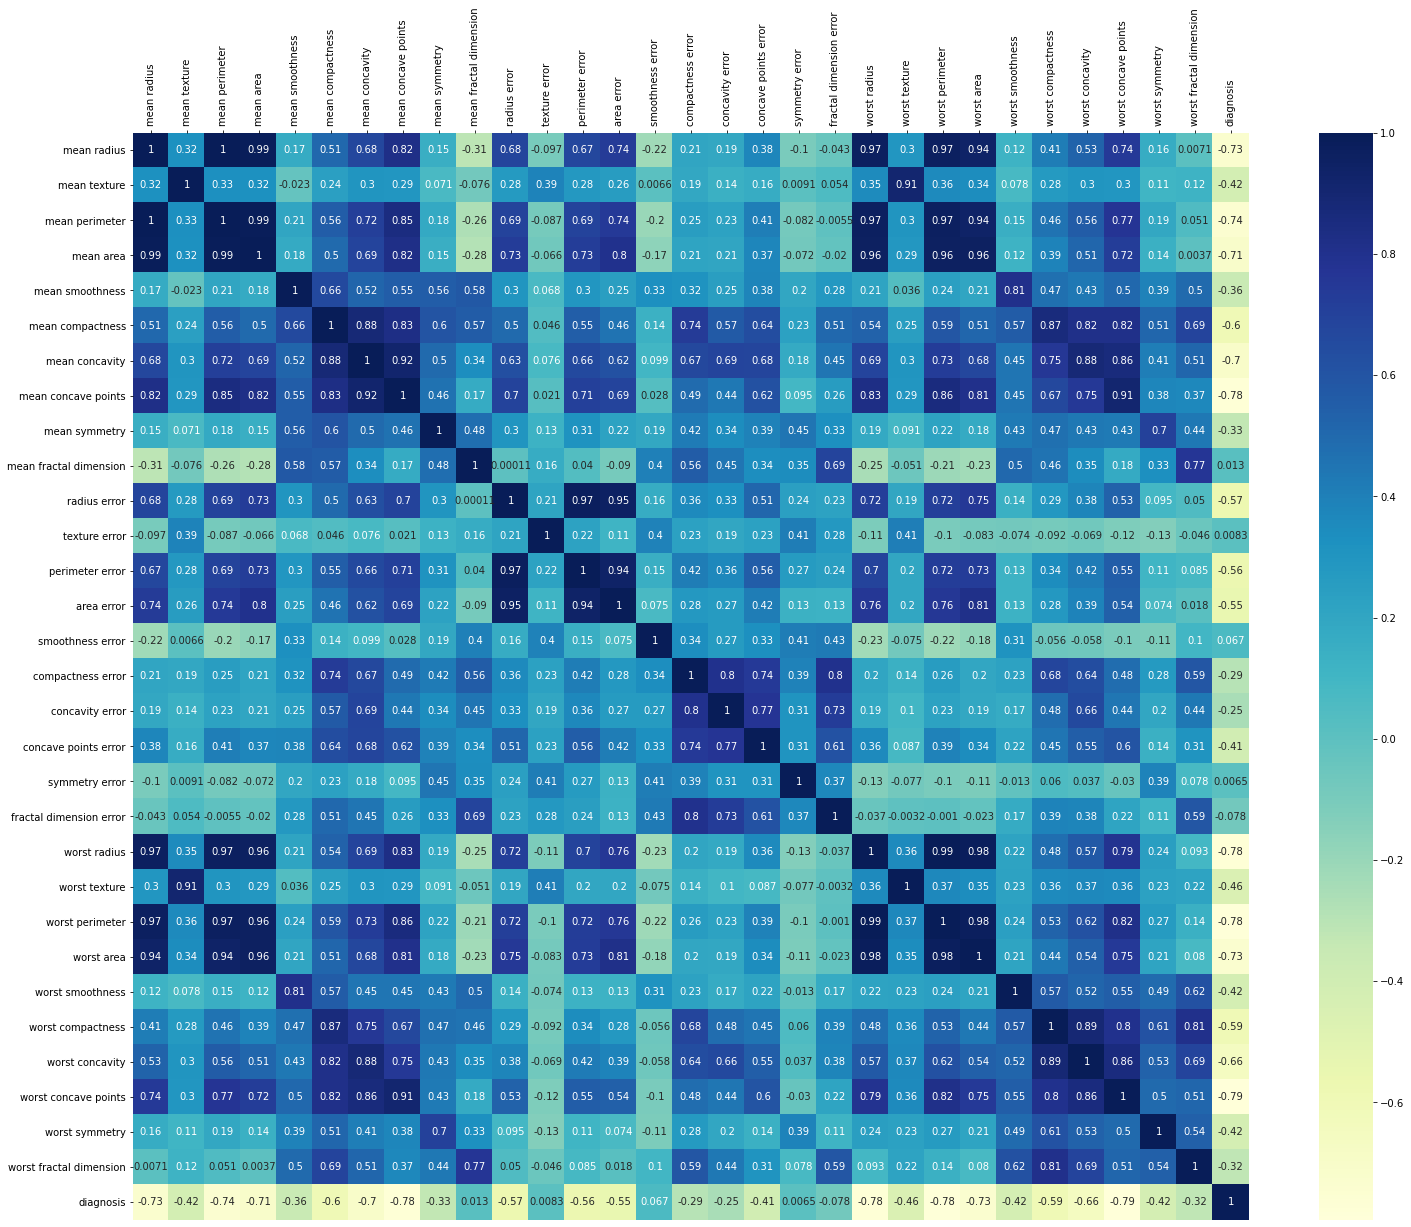

In [15]:
#plot a correlation heatmap
plt.subplots(figsize=(25,20))
hm1 = sns.heatmap(df.corr(), annot=True, cmap='YlGnBu')
hm1.set_xticklabels(hm1.get_xticklabels(), rotation=90)
hm1.xaxis.set_ticks_position('top')

This correlation heatmap helps with feature selection because the gradient shows the correlation between the columns of the dataframe. In order to select only the *significant* predictors, you must eliminate features that are highly correlated with each other (e.g. *correlation* = 0.95).

With respect to predicting the labels, the most significant predictors can be found by plotting boxplots of the numerical values against the labels. The features with boxplots that show the most variance should be chosen as the predictors for your model.

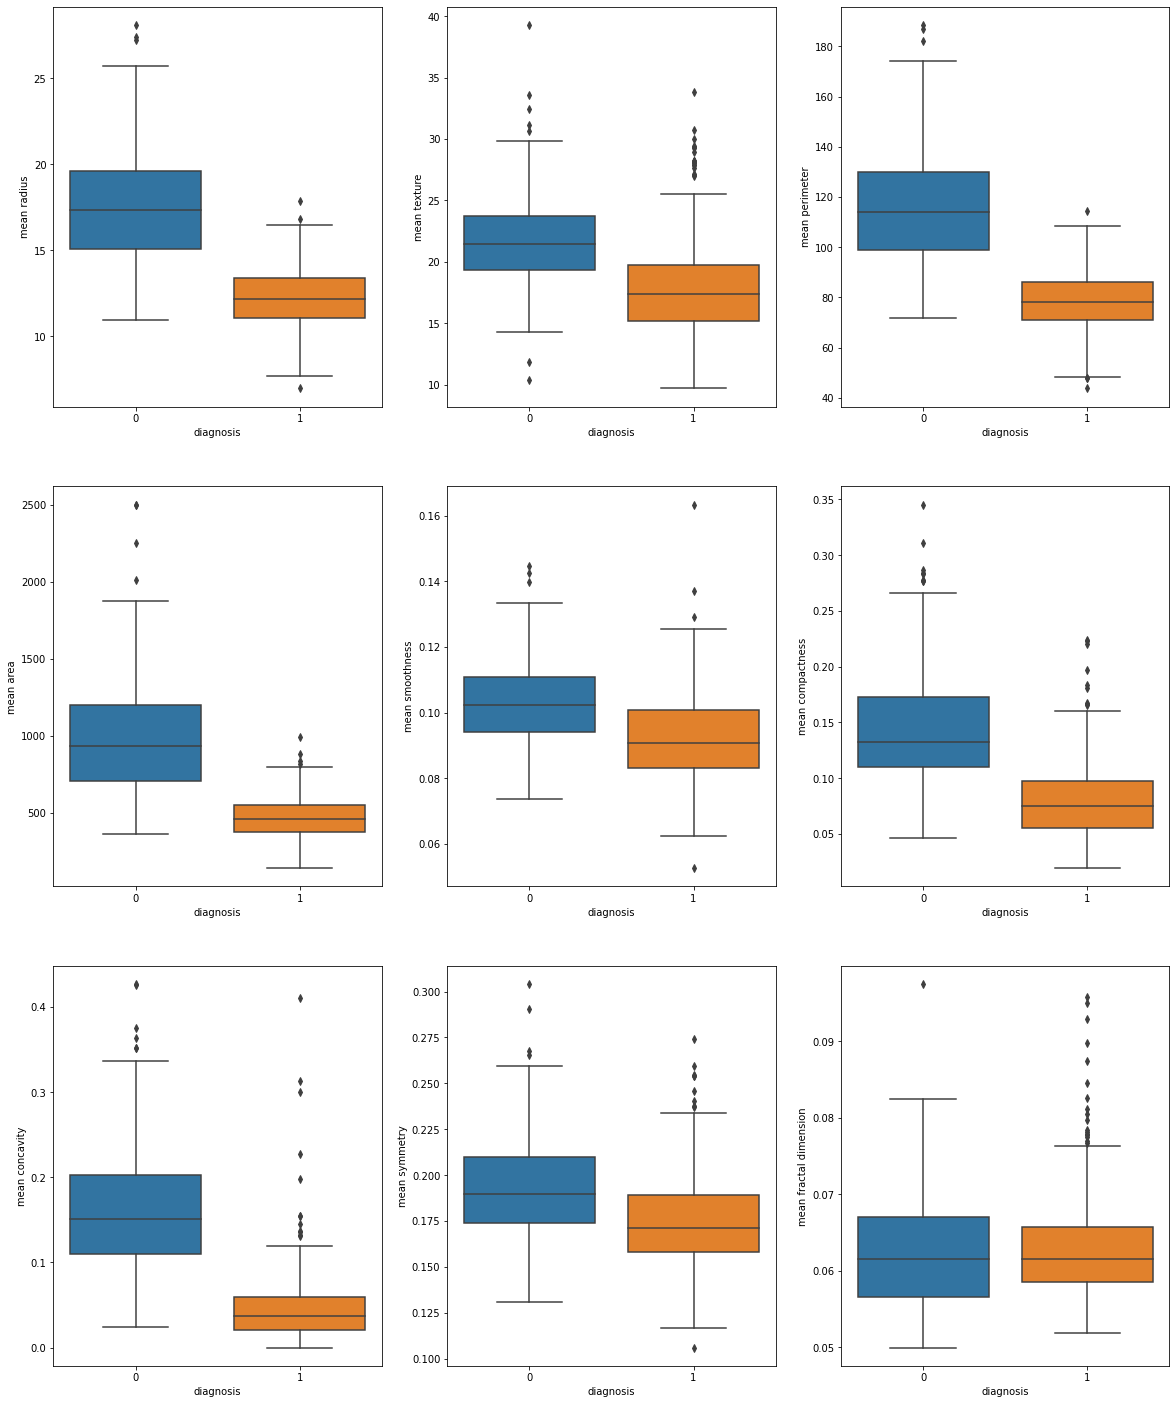

In [16]:
# plot boxplots of numerical columns
cont_list = ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean symmetry', 'mean fractal dimension']

f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(20, 25))
ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]

for i in range(len(cont_list)):
    sns.boxplot(x = 'diagnosis', y = cont_list[i], data=df, ax=ax[i])

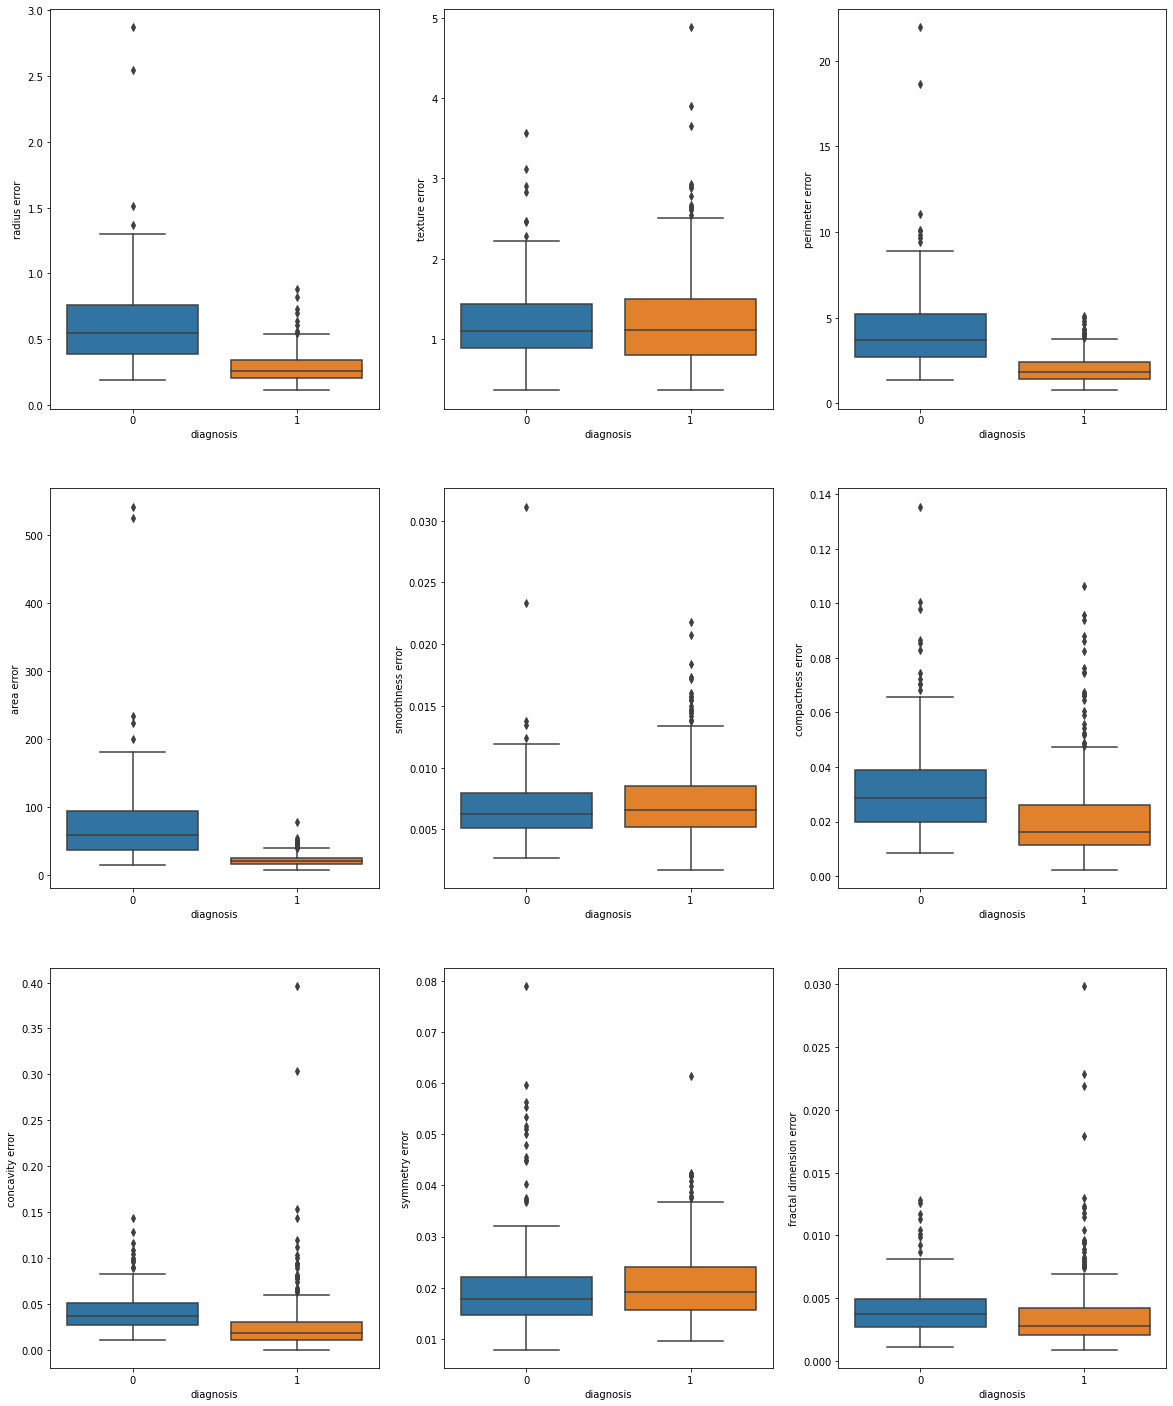

In [17]:
# Plot boxplots of numerical columns.
cont_list2 = ['radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'symmetry error', 'fractal dimension error']

f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(20, 25))
ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]

for i in range(len(cont_list2)):
    sns.boxplot(x = 'diagnosis', y = cont_list2[i], data=df, ax=ax[i])

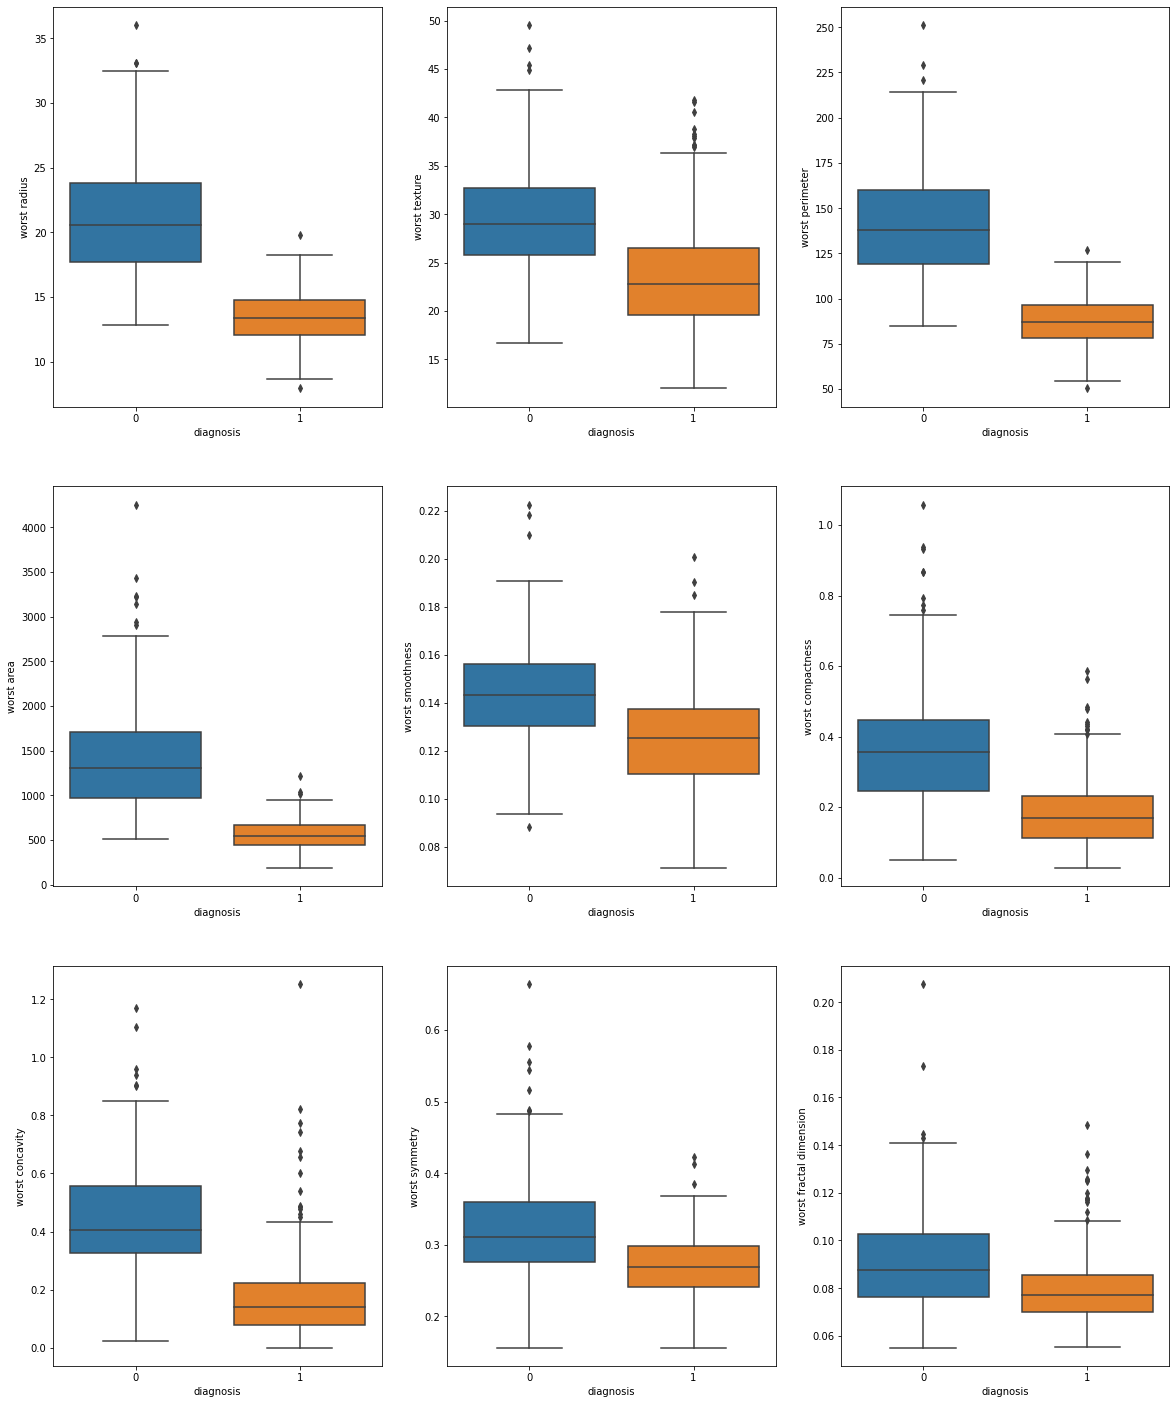

In [18]:
# Plot boxplots of numerical columns.
cont_list3 = ['worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst symmetry', 'worst fractal dimension']

f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(20, 25))
ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]

for i in range(len(cont_list3)):
    sns.boxplot(x = 'diagnosis', y = cont_list3[i], data=df, ax=ax[i])

Here are boxplots of the most significant features:

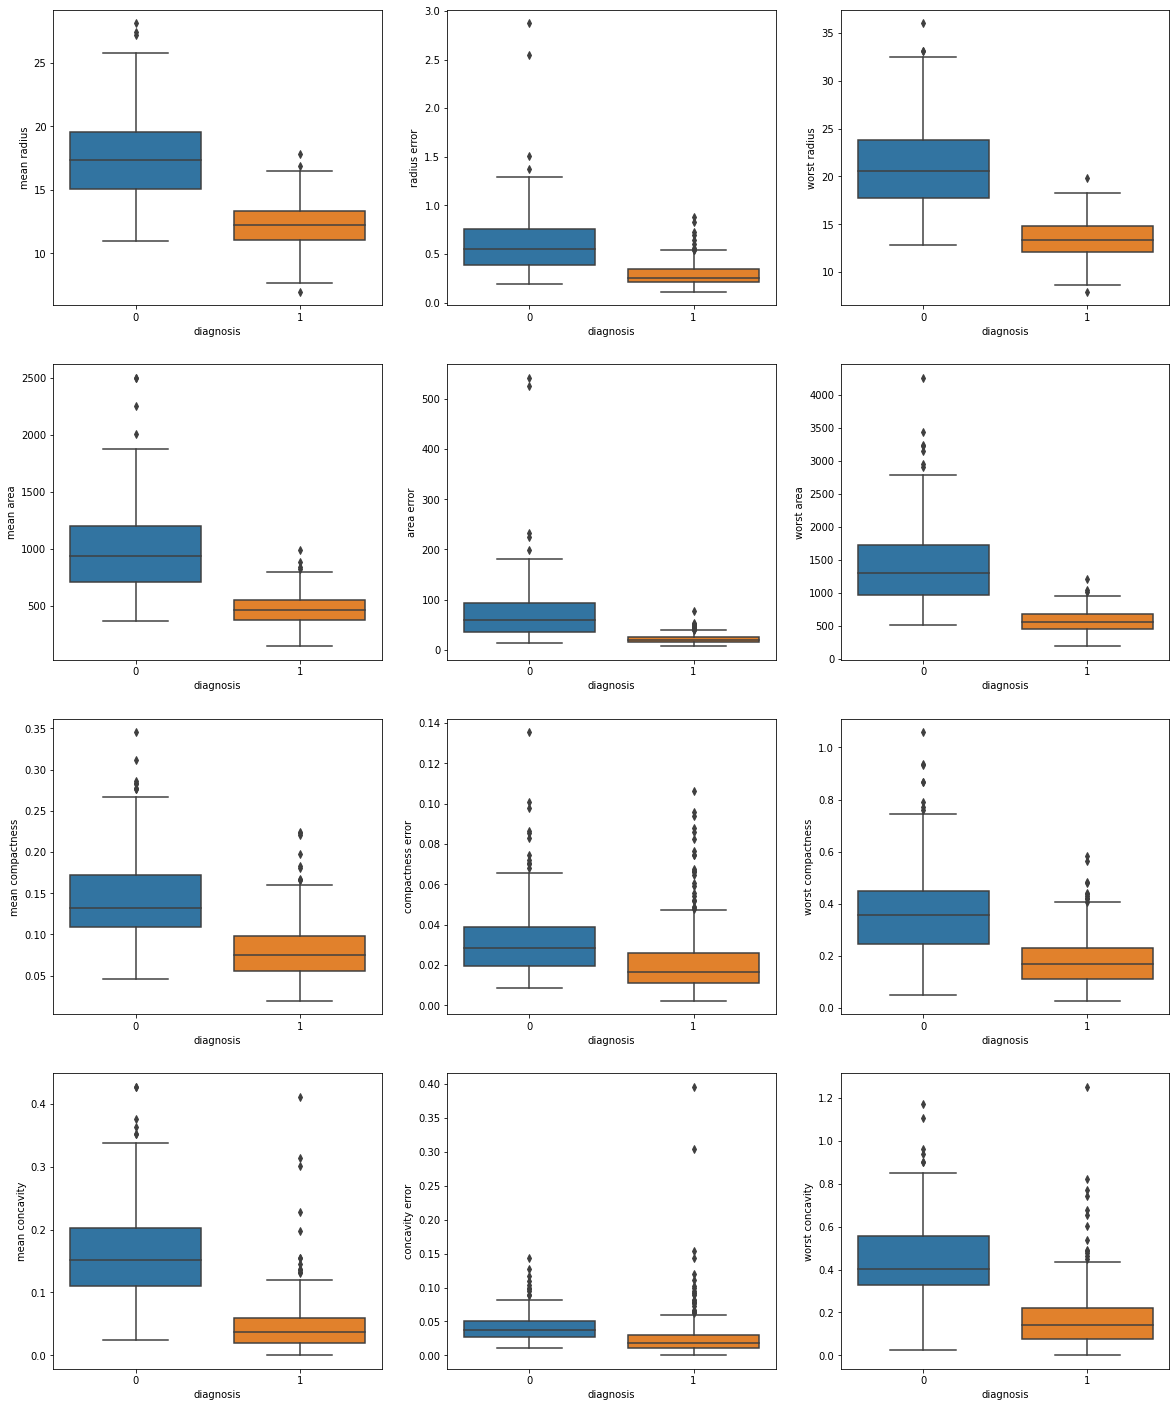

In [20]:
# Compare boxplots of significant numerical columns.
cont_list4 = ['mean radius', 'radius error', 'worst radius', 'mean area', 'area error', 'worst area', 
              'mean compactness', 'compactness error', 'worst compactness', 'mean concavity', 'concavity error', 'worst concavity']

f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9), (ax10, ax11, ax12)) = plt.subplots(4, 3, figsize=(20, 25))
ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12]

for i in range(len(cont_list4)):
    sns.boxplot(x = 'diagnosis', y = cont_list4[i], data=df, ax=ax[i])

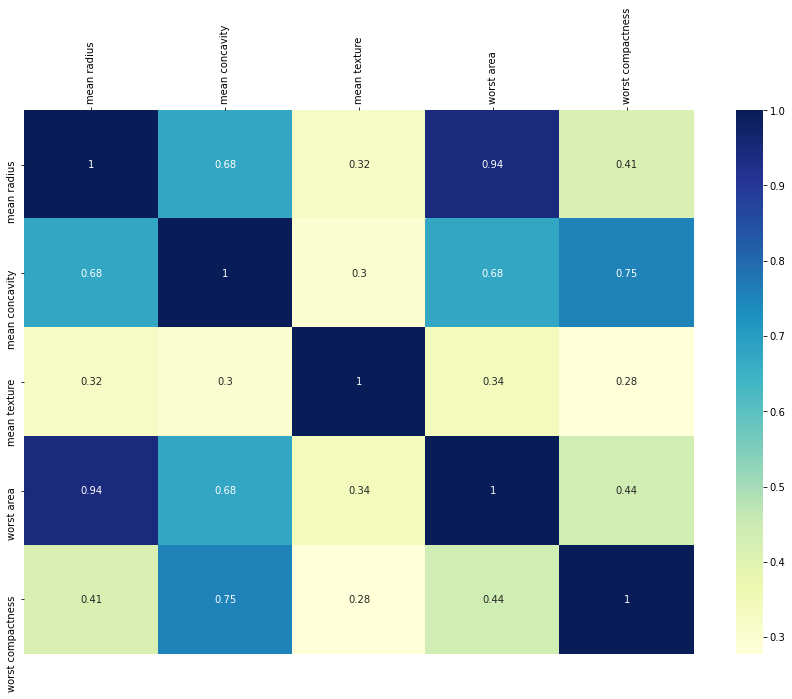

In [21]:
cont_list_f = ['mean radius', 'mean concavity', 'mean texture', 'worst area', 'worst compactness']
plt.subplots(figsize=(15,10))
hm2 = sns.heatmap(df[cont_list_f].corr(), annot=True, cmap='YlGnBu')
hm2.set_xticklabels(hm2.get_xticklabels(), rotation=90)
hm2.xaxis.set_ticks_position('top')

By plotting the boxplots of each numerical column against the diagnosis type, we have picked out the significant features/predictors. More variation in the boxplot implies higher significance. We also eliminated features that are highly correlated, therefore, we can choose *mean radius, mean concavity, mean texture, worst area, worst compactness* as the predictors for our model.

<a id='model'></a>
## 2. Create an XGBoost model

In this section, you will learn how to train and test an XGBoost model.

- [2.1 Split data](#prepare)
- [2.2 Create an XGBoost model](#create)

### 2.1 Split data<a id='prepare'></a>

You will pass the data with the selected significant predictors to build the model. You will use the `diagnosis` column as your target variable.

In [22]:
# Choosing the significant predictors.

X = df.iloc[:, [0,1,6,23,25]]
X = X.values

# Changing the target variables to binary variables
y = df['diagnosis']
y = y.values

Split the data set into: 
- Train data set
- Test data set

In [23]:
# Split the data set and create two data sets.
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=143)

In [24]:
# List the number of records in each data set.
print('Number of training records: ' + str(len(X_train)))
print('Number of testing records : ' + str(len(X_test)))

Number of training records: 369
Number of testing records : 200


The data has been successfully split into two data sets:
- The train data set, which is the largest group, will be used for training.
- The test data set will be used for model evaluation and is used to test the assumptions of the model.

### 2.2 Create an XGBoost model<a id='create'></a>

Install the required packages.<br><br>

<div class="alert alert-block alert-info">Make sure <tt>xgboost</tt>'s version is 0.82.
</div>

In [ ]:
!pip install --upgrade 'xgboost==0.82'

In [26]:
import xgboost
xgboost.__version__

'0.82'

In [27]:
# Import packages you need to create the XGBoost model.
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

#### 2.2.1 Create an XGBoost classifier

In this subsection, you will create an XGBoost classifier with default hyperparameters that you will call *xgb_model*. <br><br>

<div class="alert alert-block alert-info">The following sections will show you how to improve this base model.
</div>

In [28]:
# Create the XGB classifier - xgb_model.
xgb_model = XGBClassifier(n_estimators=100)

Display the default parameters for *xgb_model*.

In [29]:
# List the default parameters.
print(xgb_model.get_xgb_params())

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'nthread': 1, 'objective': 'binary:logistic', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'silent': True, 'subsample': 1, 'verbosity': 0}


Now, that your XGBoost classifier *xgb_model* is set up, you can train it by using the fit method. You will also evaluate *xgb_model* as the train and test data are being trained.

In [30]:
# Train and evaluate.
xgb_model.fit(X_train, y_train, eval_metric=['error'], eval_set=[((X_train, y_train)),(X_test, y_test)])

[0]	validation_0-error:0.0271	validation_1-error:0.07
[1]	validation_0-error:0.0271	validation_1-error:0.07
[2]	validation_0-error:0.0271	validation_1-error:0.07
[3]	validation_0-error:0.0271	validation_1-error:0.07
[4]	validation_0-error:0.0271	validation_1-error:0.07
[5]	validation_0-error:0.0271	validation_1-error:0.07
[6]	validation_0-error:0.0271	validation_1-error:0.07
[7]	validation_0-error:0.0271	validation_1-error:0.07
[8]	validation_0-error:0.0271	validation_1-error:0.07
[9]	validation_0-error:0.0271	validation_1-error:0.07
[10]	validation_0-error:0.0271	validation_1-error:0.07
[11]	validation_0-error:0.0271	validation_1-error:0.07
[12]	validation_0-error:0.0271	validation_1-error:0.06
[13]	validation_0-error:0.0271	validation_1-error:0.065
[14]	validation_0-error:0.0271	validation_1-error:0.055
[15]	validation_0-error:0.01897	validation_1-error:0.05
[16]	validation_0-error:0.01897	validation_1-error:0.05
[17]	validation_0-error:0.01897	validation_1-error:0.05
[18]	validation

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Plot the model performance that was evaluated during the training process to assess the model overfitting factor.

Text(0.5, 0, 'Number of iterations')

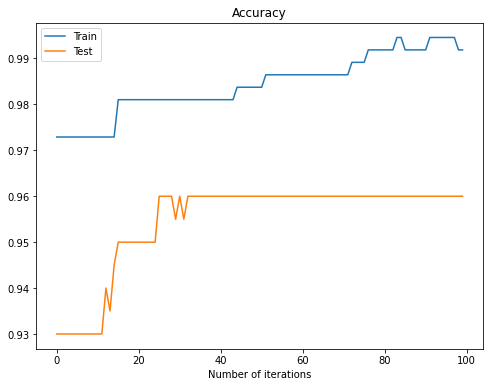

In [31]:
# Plot and display the performance evaluation
xgb_eval = xgb_model.evals_result()
eval_steps = range(len(xgb_eval['validation_0']['error']))

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(8, 6))

ax.plot(eval_steps, [1-x for x in xgb_eval['validation_0']['error']], label='Train')
ax.plot(eval_steps, [1-x for x in xgb_eval['validation_1']['error']], label='Test')
ax.legend()
ax.set_title('Accuracy')
ax.set_xlabel('Number of iterations')

You can see that there is model overfitting, and there is no increase in model accuracy after about 40 iterations.

Select the trained model obtained after 40 iterations.

In [32]:
# Select trained model.
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
n_trees = 40
y_pred = xgb_model.predict(X_test, ntree_limit= n_trees)

In [33]:
# Check the accuracy of the trained model.
accuracy = accuracy_score(y_test, y_pred)

print('Accuracy: %.2f%%' % (accuracy * 100.0))

Accuracy: 96.00%


<div class="alert alert-block alert-info">You will use the test data accuracy to compare the accuracy of the model with <i>default</i> parameters to the accuracy of the model with <i>tuned</i> parameters.
</div>

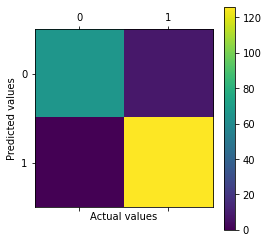

,0,1
0,66,8
1,0,126


In [34]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.matshow(cm)
plt.colorbar()
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.show()
pd.DataFrame(cm)

This confusion matrix maps the predicted values against the actual values. Here, you can see that 126 benign tumors and 66 malignant tumors have been predicted correctly. However, 8 benign tumors have been incorrectly predicted as malignant. 

Text(0, 0.5, 'True Positive Rate')

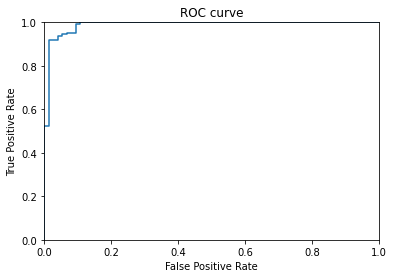

In [35]:
y_pred_prob = xgb_model.predict_proba(X_test)

# ROC-AUC curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1])
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

This is the ROC-AUC curve - the area under the curve represents the accuracy of the predictions. You can see that the area under the curve is large, indicating that the predictions are highly accurate.

#### 2.2.2 Use grid search and cross-validation to tune the model 

You can use grid search and cross-validation to tune your model to achieve better accuracy.<br><br>

<div class="alert alert-block alert-info">Grid search is used for this model as an example, but it is <b>not</b> recommended for small data sets such as this one, as it might lead to overfitting.</div>

XGBoost has an extensive catalog of hyperparameters which provides great flexibility to shape an algorithm’s desired behavior. Here you will optimize the model tuning which adds an L1 penalty (`reg_alpha`).

Use a 5-fold cross-validation because your training data set is small.

In the cell below, create the XGBoost pipeline and set up the parameter grid for the grid search. The `XGBClassifier` is a scikit-learn wrapper for xgboost classification models.

In [36]:
# Create XGBoost pipeline, set up parameter grid.
xgb_model_gs = XGBClassifier()
parameters = {'reg_alpha': [0.0, 1.0, 2.0], 'reg_lambda': [0.0, 1.0, 2.0], 'n_estimators': [n_trees], 'seed': [1337]}

Use ``GridSearchCV`` to search for the best parameters from the specified values in the previous cell.

In [37]:
# Search for the best parameters.
clf = GridSearchCV(estimator = xgb_model_gs, param_grid = parameters, scoring='accuracy', cv=5, verbose=1, n_jobs=1, refit=True, return_train_score=True)
clf.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    0.8s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'reg_alpha': [0.0, 1.0, 2.0], 'reg_lambda': [0.0, 1.0, 2.0], 'n_estimators': [40], 'seed': [1337]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=1)

From the grid scores, you can see performance results of all parameter combinations including the best parameter combination based on model performance.

In [38]:
# View the performance result.
for key in ['mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score', 'params', 'rank_test_score']:
    print(key, ": ", clf.cv_results_[key])
#clf.cv_results_

mean_train_score :  [0.9878034  0.98441125 0.98237964 0.98237964 0.98238195 0.98170397
 0.98170168 0.98035033 0.98035033]
std_train_score :  [0.00460484 0.00553239 0.00335588 0.00452269 0.00255797 0.00347903
 0.00349147 0.00396154 0.00396154]
mean_test_score :  [0.95392954 0.95392954 0.95663957 0.95121951 0.95392954 0.94850949
 0.95121951 0.94850949 0.94850949]
std_test_score :  [0.02163273 0.02887374 0.02740164 0.02477434 0.02335837 0.03647359
 0.0324458  0.03647359 0.03647359]
params :  [{'n_estimators': 40, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'seed': 1337}, {'n_estimators': 40, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'seed': 1337}, {'n_estimators': 40, 'reg_alpha': 0.0, 'reg_lambda': 2.0, 'seed': 1337}, {'n_estimators': 40, 'reg_alpha': 1.0, 'reg_lambda': 0.0, 'seed': 1337}, {'n_estimators': 40, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'seed': 1337}, {'n_estimators': 40, 'reg_alpha': 1.0, 'reg_lambda': 2.0, 'seed': 1337}, {'n_estimators': 40, 'reg_alpha': 2.0, 'reg_lambda': 0.0, 'seed': 1

Display the accuracy estimated using cross-validation and the hyperparameter values for the best model.

In [39]:
print('Best score: %.1f%%' % (clf.best_score_*100))
print('Best parameter set: %s' % (clf.best_params_))

Best score: 95.7%
Best parameter set: {'n_estimators': 40, 'reg_alpha': 0.0, 'reg_lambda': 2.0, 'seed': 1337}


Display the accuracy of the best parameter combination on the test set.

In [40]:
y_pred = clf.best_estimator_.predict(X_test, ntree_limit= n_trees)

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %.2f%%' % (accuracy * 100.0))

Accuracy: 96.00%


The test set's accuracy is about the same for both the tuned model and the trained model with default hyperparameter values, even though the tuned hyperparameters are different from the default parameters.

## 3. Setting up <a id="setup"></a>

Import the `watson-machine-learning-client` module.
<div class="alert alert-block alert-info">
For more information about the <b>Watson Machine Learning Python client (V4)</b>, please refer to the <a href="https://wml-api-pyclient-dev-v4.mybluemix.net/" target="_blank" rel="noopener no referrer">Python client documentation</a>. If you're using the notebook within a project on your WSL cluster, you do not need to install this package as it comes pre-installed with the notebooks.
</div>

In [41]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

**Authenticate the Python client on WSL 2.1.**<br>

<div class="alert alert-block alert-info">To find your authentication information (your credentials) follow the steps provided here in the <a href="https://www.ibm.com/support/knowledgecenter/SSHGWL_2.1.0/wsj/analyze-data/ml-authentication-local.html" target="_blank" rel="noopener no referrer">Documentation.</a></div>

**Action**: Enter your credentials in the following cell.

In [42]:
# Enter your credentials here
import sys,os,os.path
token = os.environ['USER_ACCESS_TOKEN']

from project_lib.utils import environment
url = environment.get_common_api_url()

wml_credentials = {
"token": token,
"instance_id" : "wml_local",
"url": url,
"version": "2.5.0"
}

Instantiate the `WatsonMachineLearningAPIClient` object.

In [43]:
client = WatsonMachineLearningAPIClient(wml_credentials)

In [44]:
client.version

'1.0.58'

You can obtain the space UID by using the following cells.

<div class="alert alert-block alert-info">
You can create your own <a href="https://www.ibm.com/support/knowledgecenter/SSHGWL_2.1.0/wsj/analyze-data/ml-spaces_local.html" target="_blank" rel="noopener no referrer">deployment space</a> by selecting <b>Deployment Spaces</b> from the Navigation Menu on the top left of this page.</div>

Alternatively, you can create a deployment and obtain its UID using the code in the following cell. The cell is not executable cell at this stage, but you can enter the name of your space in the metadata and use it if needed.

In [45]:
# Obtain the UId of your space
def guid_from_space_name(client, space_name):
    space = client.spaces.get_details()
    return(next(item for item in space['resources'] if item['entity']["name"] == space_name)['metadata']['guid'])

**Action:** Enter the name of your deployment space in the code below: `space_uid = guid_from_space_name(client, 'YOUR DEPLOYMENT SPACE')`.

In [46]:
# Enter the name of your deployment space here:
space_uid = guid_from_space_name(client, 'YOUR DEPLOYMENT SPACE')
print("Space UID = " + space_uid)

Space UID = 7760d6fb-dff6-4546-84c4-6ac90e4a371a


Setting the default space is mandatory for WSL 2.1. You can set this using the cell below.

In [47]:
client.set.default_space(space_uid)

'SUCCESS'

<a id='save'></a>
## 4. Save the model

First, you need to create the model metadata. Since the model was made using a scikit-learn wrapper for xgboost, the `TYPE` is set as `scikit-learn_0.20` and the `RUNTIME_UID` is set as `xgboost_0.82-py3.6`.

In [48]:
meta_props={
    client.repository.ModelMetaNames.NAME: "XGBoost model for breast cancer",
    client.repository.ModelMetaNames.RUNTIME_UID: "xgboost_0.82-py3.6",
    client.repository.ModelMetaNames.TYPE: "scikit-learn_0.20"
}

You can extract the model UID from the saved model details.

In [49]:
# Create the model artifact.
model_artifact = client.repository.store_model(clf.best_estimator_, meta_props)
model_uid = client.repository.get_model_uid(model_artifact)
print("Model UID = " + model_uid)

Model UID = 91033866-0f6b-4e6b-850f-074d408565a8


Get the saved model metadata using the model UID.

In [50]:
# Details about the model.
model_details = client.repository.get_details(model_uid)
from pprint import pprint
pprint(model_details)

{'entity': {'content_status': {'state': 'persisted'},
            'name': 'XGBoost model for breast cancer',
            'runtime': {'href': '/v4/runtimes/xgboost_0.82-py3.6'},
            'space': {'href': '/v4/spaces/7760d6fb-dff6-4546-84c4-6ac90e4a371a'},
            'type': 'scikit-learn_0.20'},
 'metadata': {'created_at': '2020-04-22T23:30:19.002Z',
              'guid': '91033866-0f6b-4e6b-850f-074d408565a8',
              'href': '/v4/models/91033866-0f6b-4e6b-850f-074d408565a8?space_id=7760d6fb-dff6-4546-84c4-6ac90e4a371a',
              'id': '91033866-0f6b-4e6b-850f-074d408565a8',
              'modified_at': '2020-04-22T23:30:20.002Z',
              'owner': '1000331005'}}


You can list all stored models using the `list_models` method.

In [51]:
# Display a list of all the models.
client.repository.list_models()

------------------------------------  -------------------------------  ------------------------  -----------------
GUID                                  NAME                             CREATED                   TYPE
91033866-0f6b-4e6b-850f-074d408565a8  XGBoost model for breast cancer  2020-04-22T23:30:19.002Z  scikit-learn_0.20
------------------------------------  -------------------------------  ------------------------  -----------------


<div class="alert alert-block alert-info">
From the list of stored models, you can see that model is successfully saved in your deployment space. You can view your model by selecting <b>Deployment Spaces</b> from the Navigation Menu and clicking on your deployment space name.</div>

# 5. Deploy and score the model <a id="deploy"></a>


In this section, you will learn how to create a <a href="https://www.ibm.com/support/knowledgecenter/SSHGWL_2.1.0/wsj/wmls/wmls-deploy-python.html#deploy-batch" target="_blank" rel="noopener no referrer">batch deployment</a> and score a new data record.

### 5.1 Create a model deployment

Now, you can create a deployment, *Predict breast cancer*.

In [52]:
# Deployment metadata.
deploy_meta = {
    client.deployments.ConfigurationMetaNames.NAME: "Predict breast cancer",
    client.deployments.ConfigurationMetaNames.BATCH: {},
    client.deployments.ConfigurationMetaNames.COMPUTE: {"name": "S", "nodes": 1}
}

In [53]:
# Create the deployment.
deployment_details = client.deployments.create(model_uid, meta_props=deploy_meta)



#######################################################################################

Synchronous deployment creation for uid: '91033866-0f6b-4e6b-850f-074d408565a8' started

#######################################################################################


ready.


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='8d325995-e6e4-49d3-be34-461b36d9975c'
------------------------------------------------------------------------------------------------




Get the list of all deployments.

In [54]:
# List the deployments.
client.deployments.list()

------------------------------------  ---------------------  -----  ------------------------  -------------
GUID                                  NAME                   STATE  CREATED                   ARTIFACT_TYPE
8d325995-e6e4-49d3-be34-461b36d9975c  Predict breast cancer  ready  2020-04-22T23:30:48.836Z  model
------------------------------------  ---------------------  -----  ------------------------  -------------


The *Predict breast cancer* model has been successfully deployed to your deployment space.

In [55]:
# Deployment UID.
deployment_uid = client.deployments.get_uid(deployment_details)
print('Deployment uid = {}'.format(deployment_uid))

Deployment uid = 8d325995-e6e4-49d3-be34-461b36d9975c


### 5.2 Perform prediction

Prepare the scoring payload with the values to score.

In [56]:
xgboost_input_payload = pd.DataFrame([list(X_test[i]) for i in range(-1, -9, -1)])
xgboost_input_payload

,0,1,2,3,4
0,10.82,24.21,0.01548,505.6,0.16330
1,13.48,20.82,0.10630,740.4,0.42250
2,15.46,23.95,0.20300,909.4,0.49670
3,14.29,16.82,0.00725,684.6,0.05036
4,13.00,20.78,0.03136,616.7,0.11050
5,13.66,19.13,0.09657,708.8,0.31670
6,13.90,16.62,0.02224,718.9,0.20060
7,12.76,13.37,0.04052,618.8,0.22080


Use the following code to save the payload as a .csv and add it as a data asset in your deployment space.



In [57]:
xgboost_input_payload.to_csv("xgboost_input_payload.csv", index=False, header=["f0", "f1", "f2", "f3", "f4"])
asset_details = client.data_assets.create(name="xgboost_input_payload.csv", file_path="xgboost_input_payload.csv")

Creating data asset...
SUCCESS


Retrieve the URL of the stored asset.

In [58]:
asset_href = client.data_assets.get_href(asset_details)

Prepare the job payload that you'll use to score the batch deployment.

In [59]:
# Prepare job payload.
job_payload_asset = {
    client.deployments.ScoringMetaNames.INPUT_DATA_REFERENCES: [{
        "type": "data_asset",
        "connection": {},
        "location": {
            "href": asset_href
        },
    }],
    client.deployments.ScoringMetaNames.OUTPUT_DATA_REFERENCE: {
            "type": "data_asset",
            "connection": {},
            "location": {
                "name": "xgboost_results_{}.csv".format(deployment_uid),
                "description": "results"
            }
        }
    }
pprint(job_payload_asset)

{'input_data_references': [{'connection': {},
                            'location': {'href': '/v2/assets/af6765cc-1792-49f2-9768-2ef14592697b?space_id=7760d6fb-dff6-4546-84c4-6ac90e4a371a'},
                            'type': 'data_asset'}],
 'output_data_reference': {'connection': {},
                           'location': {'description': 'results',
                                        'name': 'xgboost_results_8d325995-e6e4-49d3-be34-461b36d9975c.csv'},
                           'type': 'data_asset'}}


Use the following method to run the scoring.

In [60]:
job = client.deployments.create_job(deployment_id=deployment_uid, meta_props=job_payload_asset)
job_uid = client.deployments.get_job_uid(job)
print('Job uid = {}'.format(job_uid))

Job uid = 421894f4-b46f-407d-a2fd-91cf23314ac9


In [61]:
def poll_async_job(client, job_uid):
    import time
    while True:
        job_status = client.deployments.get_job_status(job_uid)
        print(job_status)
        state = job_status['state']
        if state == 'completed' or 'fail' in state:
            return client.deployments.get_job_details(job_uid)
        time.sleep(5)

In [62]:
# Perform prediction.
job_details_asset = poll_async_job(client, job_uid)
pprint(job_details_asset)

{'state': 'queued', 'running_at': '', 'completed_at': ''}
{'state': 'queued', 'running_at': '', 'completed_at': ''}
{'state': 'queued', 'running_at': '', 'completed_at': ''}
{'state': 'completed', 'running_at': '2020-04-22T23:31:21.765576Z', 'completed_at': '2020-04-22T23:31:22.621584Z'}
{'entity': {'deployment': {'href': '/v4/deployments/8d325995-e6e4-49d3-be34-461b36d9975c'},
            'scoring': {'input_data_references': [{'connection': {},
                                                   'location': {'href': '/v2/assets/af6765cc-1792-49f2-9768-2ef14592697b?space_id=7760d6fb-dff6-4546-84c4-6ac90e4a371a'},
                                                   'type': 'data_asset'}],
                        'output_data_reference': {'connection': {},
                                                  'location': {'description': 'results',
                                                               'href': '/v2/assets/6b5e52b6-dd7c-43c6-b43d-f57a5b8e010d?space_id=7760d6fb-dff6-4546-

You can see your that the `xgboost results` .csv has been created as a data asset.

In [63]:
client.data_assets.list()

--------------------------------------------------------  ----------  ----  ------------------------------------
NAME                                                      ASSET_TYPE  SIZE  ASSET_ID
xgboost_input_payload.csv                                 data_asset  275   af6765cc-1792-49f2-9768-2ef14592697b
xgboost_results_8d325995-e6e4-49d3-be34-461b36d9975c.csv  data_asset  393   6b5e52b6-dd7c-43c6-b43d-f57a5b8e010d
--------------------------------------------------------  ----------  ----  ------------------------------------


Get the UID of the results .csv and download the data asset.

In [64]:
import re
results_asset = job_details_asset['entity']['scoring']['output_data_reference']['location']['href']
results_uid = re.split('[?/]', results_asset)[3]
results_uid

'6b5e52b6-dd7c-43c6-b43d-f57a5b8e010d'

You can see the values predicted by the model here.

In [65]:
client.data_assets.download(results_uid, "scoring_results.csv")

Successfully saved asset content to file: 'scoring_results.csv'


'/home/wsuser/work/scoring_results.csv'

In [66]:
pd.read_csv("scoring_results.csv")

,prediction,probability
0,1,"[0.036061882972717285, 0.9639381170272827]"
1,0,"[0.5728256702423096, 0.4271743595600128]"
2,0,"[0.967219352722168, 0.032780636101961136]"
3,1,"[0.06339657306671143, 0.9366034269332886]"
4,1,"[0.024533510208129883, 0.9754664897918701]"
5,1,"[0.04722827672958374, 0.9527717232704163]"
6,1,"[0.03073573112487793, 0.9692642688751221]"
7,1,"[0.022901535034179688, 0.9770984649658203]"


The first 2 patients here are predicted to have malignant and benign tumors respectively.

You can delete the 2 created data assets using the code below.

In [67]:
client.data_assets.delete(client.data_assets.get_uid(asset_details))
client.data_assets.delete(results_uid)

'SUCCESS'

<a id='summary'></a>
## 6. Summary and next steps     

You have successfully completed this notebook! 

You learned how to use a machine learning algorithm called XGBoost as well as Watson Machine Learning to create a model and a batch deployment. 

### Resources <a id="resources"></a>

To learn more about configurations used in this notebook or more sample notebooks, tutorials, documentation, how-tos, and blog posts, check out these links:

<div class="alert alert-block alert-success">

<h4>IBM documentation</h4>
 <ul>
 <li> <a href="https://wml-api-pyclient-dev-v4.mybluemix.net" target="_blank" rel="noopener no referrer">watson-machine-learning</a></li> 
 <li> <a href="https://www.ibm.com/support/knowledgecenter/SSHGWL_2.1.0/wsj/local/welcome.html" target="_blank" rel="noopener noreferrer">Watson Studio Local 2.1</a></li>
 <li> <a href="https://www.ibm.com/support/knowledgecenter/SSHGWL_2.1.0/wsj/wmls/deploy-models.html#batch" target="_blank" rel="noopener no referrer">Batch Deployments</a></li>
     <ul>
         <li> <a href="https://www.ibm.com/support/knowledgecenter/SSHGWL_2.1.0/wsj/wmls/wmls-deploy-python.html#deploy-batch" target="_blank" rel="noopener no referrer">Batch Deployments with the Python client</a></li>
    </ul>
 </ul>
 
<h4> IBM Samples</h4>
<br>
 <li> <a href="https://github.com/IBMDataScience/sample-notebooks" target="_blank" rel="noopener noreferrer">Sample notebooks</a></li>
 
<h4> Others</h4>
<ul>
 <li> <a href="https://www.python.org" target="_blank" rel="noopener noreferrer">Official Python website</a></li>
     <ul>
     <li> <a href="https://pixiedust.github.io/pixiedust/" target="_blank" rel="noopener noreferrer">PixieDust</a></li>
     <li> <a href="https://matplotlib.org" target="_blank" rel="noopener noreferrer">Matplotlib: Python plotting</a></li>
     <li> <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html" target="_blank" rel="noopener noreferrer">scikit-learn: Grid Search</a></li>
     </ul>
 <li> <a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html" target="_blank" rel="noopener noreferrer">Pandas DataFrame</a></li>
 <li> <a href="https://seaborn.pydata.org" target="_blank" rel="noopener noreferrer">Seaborn</a></li>
</ul>
 </div>

### Citation

Lichman, M. (2013). [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml). Irvine, CA: University of California, School of Information and Computer Science.

### Authors

**Wojciech Sobala** is a Data Scientist at IBM.  
**Ananya Kaushik** is a Data Scientist at IBM.

<hr>
Copyright © 2017-2020 IBM. This notebook and its source code are released under the terms of the MIT License.

<div style='background:#F5F7FA; height:110px; padding: 2em; font-size:14px;'>
<span style='font-size:18px;color:#152935;'>Love this notebook? </span>
<span style='font-size:15px;color:#152935;float:right;margin-right:40px;'>Don't have an account yet?</span><br>
<span style='color:#5A6872;'>Share it with your colleagues and help them discover the power of Watson Studio!</span>
<span style='border: 1px solid #3d70b2;padding:8px;float:right;margin-right:40px; color:#3d70b2;'><a href='https://ibm.co/wsnotebooks' target='_blank' style='color: #3d70b2;text-decoration: none;'>Sign Up</a></span><br>
</div>